In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
TRAIN_DATASET_PATH = './data.csv'
#train = pd.read_csv('train.csv').fillna('').sample(frac=1)
#train.head(3)

In [8]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [10]:
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [11]:
TARGET_NAME = 'target'

In [12]:
df[TARGET_NAME].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [13]:
NUM_FEATURE_NAMES = ['history']
CAT_FEATURE_NAMES = ['recency', 'channel', 'treatment']
BASE_FEATURE_NAMES = ['used_discount', 'used_bogo', 'zip_code', 'is_referral']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + BASE_FEATURE_NAMES

In [14]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [15]:
df.loc[df['treatment'] =="Buy One Get One", 'treatment'] = 1
df.loc[df['treatment'] =="Discount", 'treatment'] = 1
df.loc[df['treatment'] =="No Offer", 'treatment'] = 0

In [16]:
t = ['zip_code', 'channel']
for tt in t:
    k = 0
    for i in df[tt].unique():
        df.loc[df[tt] == i, tt] = k
        k = k + 1
    df[tt]=  pd.to_numeric(df[tt], errors='coerce')

In [17]:
for i in SELECTED_FEATURE_NAMES:
    df[i].fillna(df[i].mode()[0], inplace=True)    

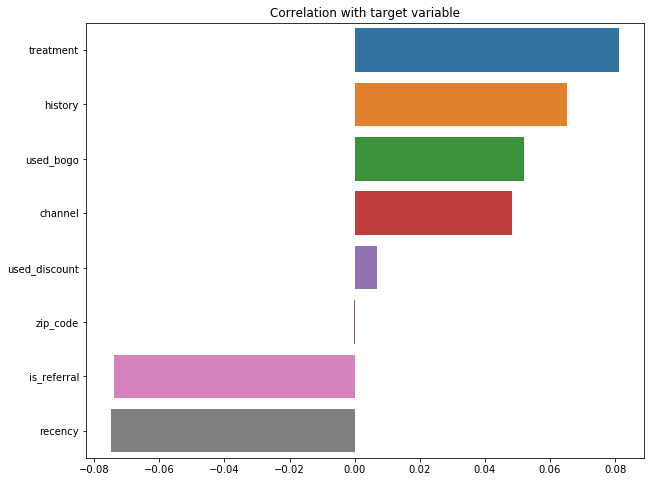

In [18]:
corr_with_target = df[SELECTED_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [19]:
#plt.figure(figsize = (20,15))

#sns.set(font_scale=1.4)

#corr_matrix = df[BASE_FEATURE_NAMES].corr()
#corr_matrix = np.round(corr_matrix, 2)
#corr_matrix[np.abs(corr_matrix) < 0.3] = 0

#sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

#plt.title('Correlation matrix')
#plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [23]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,-0.389003,1,0,0,0,0,1,0
1,6,0.339614,1,1,1,1,1,0,0
2,7,-0.239836,0,1,0,1,1,1,0
3,9,1.693278,1,0,1,1,1,1,0
4,2,-0.768068,1,0,2,0,1,1,0


Save current dataset

In [22]:
UPDATED_DATASET_PATH = './new_train.csv'
df.to_csv(UPDATED_DATASET_PATH, index=False, encoding='utf-8')

Model learning